# Browning trends XGBoost model - local run with loop

### Peter R.
#### 2025-03-11

Here we use BFAST breaks derived from 20-years of forest EVI (enhanced vegetation index) time series (ts) observations. These breaks were produced using a BFAST *h* parameter equal to 0.05 (or ~ 5% of the ts) and used in Extreme Gradient Boosting (XGBoost) models. The response variable is (forest EVI) magnitude of break and predictors are forest and climate-related variables. The code below is for negative breaks only.  

The data used here were produced with R and DuckDb. Climate variables were shortlisted using variation inflation factor (VIF). The code for putting the data frame together is not shown here.

An important number of Bfast breaks had wide 95% confidence intervals (CIs) associated with the time of break. These 95% CIs  ranged from about 1 month to 80+ months. These records provide poor quality matching with yearly forest, climate and disturbance data. For this reason, we decided to test XGB models (boosted regression trees, BRT) with subsets of data with narrow 95% CIs. The following XGB models and dataframe subsets are run:

- Dataframe3 (df3): Records with 95% CIs shorter than 3 16-days data points (48 days or about 1.5 months)

- Dataframe6 (df6): Records with 95% CIs shorter than 6 16-days data points (96 days or about 3 months)

- Dataframe9 (df9): Records with 95% CIs shorter than 9 16-days data points (144 days or about 5 months)

- Dataframe23 (df23): Records with 95% CIS shorter than 23 16-days data points (368 days or about 1 year)

This notebook has three main parts. The first one runs XGBoost with different subsets of the data. The second part does the same but removes records matched with disturbance data. The last part, runs the best model and creates figures.

Some points to have in mind:

- Some of the XGBoost parameter values used below were obtained by using RandomizedSearchCV available in Scikit-learn. This step  is not shown here.

- Given that Global Forest Change (Hansen *et al.* 2013) had the most matches (spatiotemporal overlap) with break data we used this data source to filter out matched breaks. This was done so that variation by forest and climate-related predictors can be better tunned in.


### Setup

In [12]:
# Peter R.
# XGBoost script

#Here I am using a loop to run several models at a time

import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# for feature importance plots
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

#for dependency plots
from sklearn.inspection import PartialDependenceDisplay

#start = time.time()

# Get the current working directory
cwd = os.getcwd()

#print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")
# Win directory
os.chdir(r'C:\Users\Peter R\github\forc_stpa\models\xgboost\exploratory')


print("XGB version:", xgb.__version__)
print("negative trends")


# Windows
df1 = pd.read_csv(r'.\data\df2_trends_p1_vars_browning_v4_strs1.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df11 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)
df11 = pd.get_dummies(df11, columns=['gfc'], dtype=float)
df11 = pd.get_dummies(df11, columns=['canlad'], dtype=float)



XGB version: 1.7.6
negative trends


In [13]:
# Notes
# - Here I am reorganizing the columns so that all dfs have the outcome as the first column
#Df0: all rows (including nulls)
df0 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0)]

# Df3:
#df3 = df11.dropna()
#df3 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0)]
#df3.describe()

#df3 = df0.loc[(df0['canlad'] > 0) ]


#dfall = [df0, df3, df6, df9, df23]
#dfall = [df0, df3] # df0 & df3 are the same df so far
dfall = [df0]


#Df0: all rows
#dfall = [df11]


In [14]:
print(dfall[0].describe())  # 10127 # canlad > 0: 1528

                 pix    year  for_age_2003  for_con_2003        elev  \
count     788.000000   788.0    788.000000    788.000000  788.000000   
mean   214872.538071  2003.0     88.062392     38.612222  362.184675   
std    143843.976794     0.0     13.944724     19.130558   80.923581   
min       769.000000  2003.0     53.732000      5.861000  169.644000   
25%    100407.750000  2003.0     78.160000     23.048500  302.940000   
50%    188526.500000  2003.0     86.035000     34.947500  365.432000   
75%    350046.250000  2003.0     95.583500     54.522250  429.034250   
max    493321.000000  2003.0    134.896000     87.667000  528.451000   

       p1_trend  p1_trend_slope  trend_20yrs  delta_for_age_lag3  \
count     788.0      788.000000   546.000000                 0.0   
mean        2.0       -5.582680     1.375458                 NaN   
std         0.0        2.513868     1.203993                 NaN   
min         2.0      -19.088000     1.000000                 NaN   
25%        

In [15]:
(dfall[0]).head()
#range(len(dfall))

,pix,year,for_age_2003,for_con_2003,elev,p1_trend,p1_trend_slope,trend_20yrs,delta_for_age_lag3,delta_for_con_lag3,...,dd5_wt_rel30,cmi_sm_rel30_reg,dd5_wt_rel30_reg,canlad_factor,for_pro_0,for_pro_1,gfc_0,gfc_1,canlad_0,canlad_1
0,115067,2003,95.448,53.656,259.379,2,-4.034,1.0,NaN,NaN,...,0.35000,2.601,1.440,0,1.0,0.0,0.0,1.0,1.0,0.0
1,228706,2003,106.325,18.580,426.962,2,-4.324,1.0,NaN,NaN,...,0.61200,1.300,1.719,0,1.0,0.0,1.0,0.0,1.0,0.0
2,365696,2003,109.414,34.935,460.843,2,-3.649,NaN,NaN,NaN,...,0.60000,1.498,1.707,0,1.0,0.0,1.0,0.0,1.0,0.0
3,454234,2003,82.610,44.833,404.781,2,-3.472,5.0,NaN,NaN,...,0.88725,2.064,2.013,0,1.0,0.0,1.0,0.0,1.0,0.0
4,215858,2003,80.388,25.850,323.298,2,-3.449,1.0,NaN,NaN,...,0.52075,2.349,1.622,0,1.0,0.0,1.0,0.0,1.0,0.0


In [16]:
# Count NAs per columns. These NAs are correct as nan. the rad variables above had -9999 values which could have biased the results.
# Hence, the rad vars were dropped.
df0.isna().sum()

pix             0
year            0
for_age_2003    0
for_con_2003    0
elev            0
               ..
for_pro_1       0
gfc_0           0
gfc_1           0
canlad_0        0
canlad_1        0
Length: 94, dtype: int64

In [31]:
# List with all column names
#print(df0.columns.tolist())

###  1. Models with all records

In [20]:
# loop version

#cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
#cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
#cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

#cols1 = ['for_age_2003','for_con_2003', 'delta_for_age','delta_for_con', 'delta_cmi_sm_lag3', 'delta_cmi_sm', 'delta_dd5_wt', 'for_pro_0', 'gfc']
#cols1 = ['for_age_2003','for_con_2003', 'delta_for_age','delta_for_con', 'delta_cmi_sm_lag1','delta_cmi_sm_lag2', 'delta_cmi_sm_lag3', 'delta_cmi_sm', 'delta_dd5_wt_lag1', 'delta_dd5_wt_lag2', 'delta_dd5_wt_lag3', 'delta_dd5_wt', 'for_pro_0', 'gfc']

# VIF columns + protected
#cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']

# VIF columns + protected + disturbance
#cols3 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0', 'gfc', 'canlad', 'harv']

# Base model
cols1 = ['for_age_2003','for_con_2003', 'delta_for_age','delta_for_con', 'delta_cmi_sm_lag1','delta_cmi_sm_lag2', 
         'delta_cmi_sm_lag3', 'delta_cmi_sm', 'delta_dd5_wt_lag1', 'delta_dd5_wt_lag2', 'delta_dd5_wt_lag3', 'delta_dd5_wt',
         'for_pro_0', 'canlad_0']

# VIF columns + protected
cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']

# VIF columns + protected + disturbance
cols3 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0', 
       'canlad_0']

# VIF columns (with normals based vars) + protected 
cols4 = ['delta_dd5_wt_lag3', 'avg_for_con', 'delta_for_age', 'delta_for_con', 'cmi_sm_cqv', 'max_cmi_sm_rel30', 
         'max_cmi_sm_rel30_reg', 'for_pro_0']

# VIF columns + protected + regional/relative to normals (manual) + disturbance
cols5 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2','delta_cmi_sm_lag1','avg_for_con', 'delta_for_age', 'delta_for_con', 
         'cmi_sm_rel30' , 'dd5_wt_rel30', 'cmi_sm_rel30_reg', 'dd5_wt_rel30_reg', 'for_pro_0', 'canlad_0']

#cols7 = ['canlad_0']

#df_labs = ['df0','df3', 'df6', 'df9', 'df23']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
df_labs = ['df0', 'df3']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
model_labs = ['Base model', 'VIF+pro', 'VIF+pro+dist', 'VIFplus+pro', 'VIF+manual']
#df_labs = ['df0', 'df3']
#model_labs = ['First variable set', 'VIFplus variable set']


# Index 6 has the slope for period 1 after recoding for_pro

for z in range(len(dfall)):
    list_of_vars = [[cols1], [cols2], [cols3], [cols4], [cols5]]
    #list_of_vars = [[cols1]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

            # row for table
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")
            
        

| 1 | df0 | Base model | 3.58 | 1.89 | 0.292 | 0.252 | 788 | 14 |
| 1 | df0 | VIF+pro | 4.16 | 2.04 | 0.176 | 0.156 | 788 | 6 |
| 1 | df0 | VIF+pro+dist | 3.75 | 1.94 | 0.258 | 0.237 | 788 | 7 |
| 1 | df0 | VIFplus+pro | 4.06 | 2.02 | 0.196 | 0.170 | 788 | 8 |
| 1 | df0 | VIF+manual | 3.60 | 1.90 | 0.287 | 0.252 | 788 | 12 |


**Table 2**: Model comparison for browning trendss. Standard data set with all records.


|ID|Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj |N rows| N vars|
| --------| --------| --------| --------| -------- | ------- |-------- | ------- |------- |
| 1 | df0 | First variable set | 1.69 | 1.30 | 0.457 | 0.455 | 10127 | 14 |
| 2 | df0 | VIF variable set | 1.96 | 1.40 | 0.370 | 0.369 | 10127 | 6 |
| 3 | df0 | VIFplus variable set | 1.79 | 1.34 | 0.425 | 0.423 | 10127 | 9 |
| 4 | df0 | VIFplus2 | 2.31 | 1.52 | 0.261 | 0.259 | 10127 | 8 |
| 5 | df0 | VIFplus3 | 1.84 | 1.36 | 0.411 | 0.409 | 10127 | 7 |

| 1 | df0 | First variable set | 1.67 | 1.29 | 0.469 | 0.467 | 10127 | 14 |
| 1 | df0 | VIF variable set | 1.86 | 1.36 | 0.411 | 0.409 | 10127 | 6 |
| 1 | df0 | VIFplus variable set | 1.64 | 1.28 | 0.481 | 0.479 | 10127 | 9 |
| 1 | df0 | VIFplus2 | 2.31 | 1.52 | 0.267 | 0.265 | 10127 | 8 |
| 1 | df0 | VIFplus3 | 1.68 | 1.29 | 0.468 | 0.467 | 10127 | 7 |
| 1 | df0 | VIFplus4 | 1.80 | 1.34 | 0.429 | 0.427 | 10127 | 11 |
| 1 | df0 | Only disturbance | 2.55 | 1.60 | 0.190 | 0.190 | 10127 | 1 |











In [22]:
#print(delta_)
for z in range(len(dfall)):
    list_of_vars = [[cols1]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            print(dfall[z].iloc[:,6].abs())
            print(dfall[z][x])
    
    
#['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1']
    

0       4.034
1       4.324
2       3.649
3       3.472
4       3.449
        ...  
795    12.998
796     8.625
797     6.738
798     6.753
799     5.462
Name: p1_trend_slope, Length: 788, dtype: float64
     for_age_2003  for_con_2003  delta_for_age  delta_for_con  \
0          95.448        53.656         -5.940         -3.514   
1         106.325        18.580         -0.431          8.038   
2         109.414        34.935          3.870         -4.375   
3          82.610        44.833         -6.057          2.226   
4          80.388        25.850         13.037         -2.323   
..            ...           ...            ...            ...   
795        91.970        46.810          0.365         -0.304   
796        77.681        48.852         -1.418         -3.962   
797        91.076        71.107          0.238          2.153   
798        89.639        63.966         -2.113        -14.715   
799        75.155        59.763         -7.470         -8.604   

     delta_cmi_

###  2. Models without records that have disturbance matches

When dealing with negative forest EVI breaks, those records matched with disturbance data can be considered explained. This is, we know what caused the negative breaks. You would expect that most negative breaks would have a match in space-time with disturbance data (remote sensing derived). However, there were a significant amount of negative breaks that could not be matched. Perhaps some of these unmatched breaks could have overlapped with other disturbanced data that we did not have (i.e., windthrows). Below negative breaks that matched with Hansen et al.'s (2013) disturbance data were removed and XGBoost models with climate and forest-related data were run.

In [139]:
# How many records are matched to disturbance data?
#print(df2[['hansen_year']].describe()) # N=2775
#print(df2[['magnitude', 'fire_year', 'harv_year', 'canlad_year', 'hansen_year']].describe()) # Hansen=? with df4; Hansen=648 with df5

In [50]:
#df0 = all records
df0 = df0.loc[df0['hansen_year'].isnull()] 
# Df3: 1.5 months
df3 = df3.loc[df3['hansen_year'].isnull()]
# Df6: 3 months
df6 = df6.loc[df6['hansen_year'].isnull()] 
# Df9: 5 months, version 4
df9 = df9.loc[df9['hansen_year'].isnull()] 
# Df23: 12 months, 1 year, version 5
df23 = df23.loc[df23['hansen_year'].isnull()] 

dfall = [df0, df3, df6, df9, df23]

In [52]:
dfall[1].shape

(37, 158)

In [55]:
# check one more
# df2.shape
X1.shape

(3086, 9)

### 3. Best Model

The best model for positive breaks was ID=5 in Table 1 (df3, VIF variable set). A close second was ID=6 in Table 1 (df3, VIFplus variable set) without removed disturbance record matches. Given that I want to keep some conistency among the XGBoost models for positive and negative breaks. I will choose ID=6 (Table 1) as the best model. This way both negative and positive breaks have the same set of variables. Note that the best model only has 116 records, that is only about 1% of the original data frame.

Below are the corresponding plots for this model.

In [23]:
# This df3 is the non-distubance filtered version (Table 1 above). So, we need to re-create the df.
#df3 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude'] < -500)] #N= 116
#dfall2 = [df3] 

dfall2 = [df0]

In [24]:
# check one more
# df2.shape
dfall2[0].shape

(788, 94)

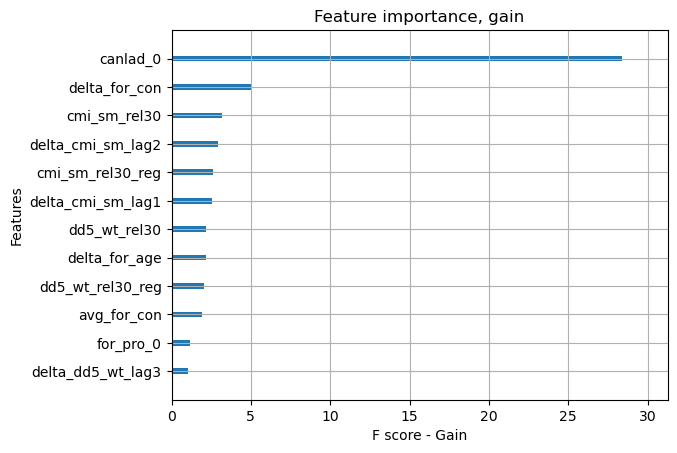

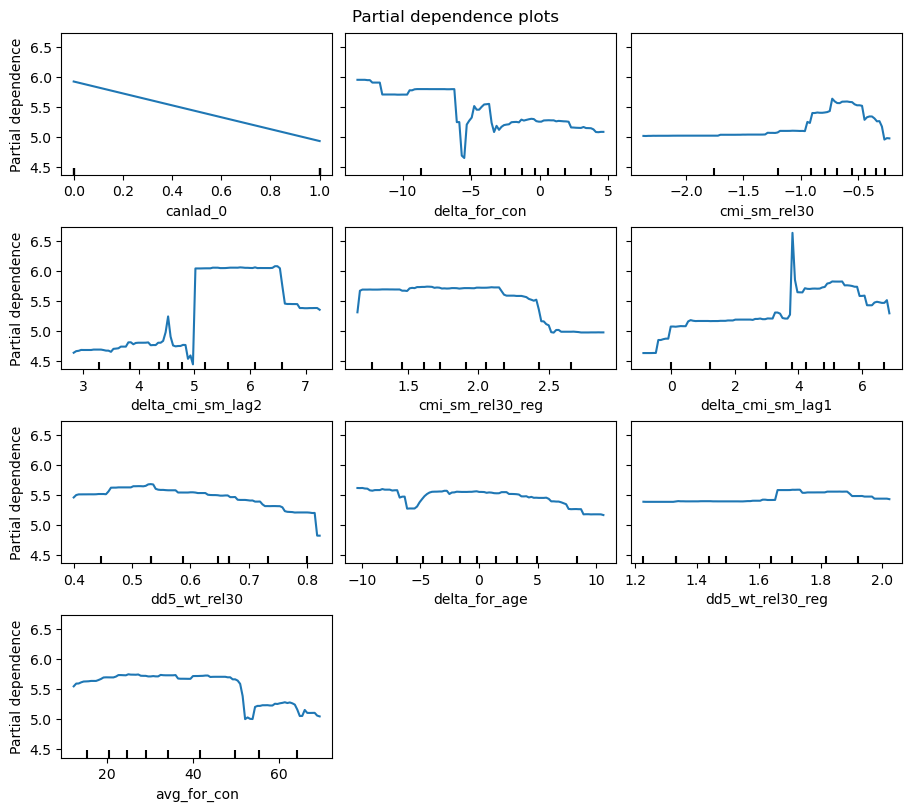

In [25]:
# Create new df
dfall2 = [df0]
# check once more
# df2.shape
dfall2[0].shape

# column object created above. No need to create it again

for z in range(len(dfall2)):
    list_of_vars = [[cols5]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall2[z][x]
            #print(X1.describe())
            y1 = dfall2[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))           
            
            # Feature importance plot
            xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                        xlabel='F score - Gain', ylabel='Features', 
                        importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            pyplot.savefig(r'.\figs\version1\neg_gain_m{y}_v4_strs1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            features_names1 = pd.DataFrame()
            features_names1['columns'] = X1.columns
            features_names1['importances'] = model_bp2.feature_importances_
            features_names1.sort_values(by='importances',ascending=False,inplace=True)
            features_names2 = features_names1['columns'].tolist()[0:10]

            # Partial dependence plots
            _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            pyplot.savefig(r'.\figs\version1\neg_partial_dep_m{y}_v4_strs1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

            pyplot.show()


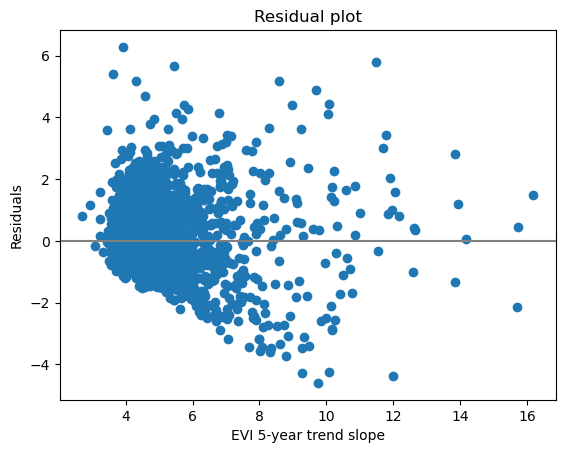

In [40]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI 5-year trend slope")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

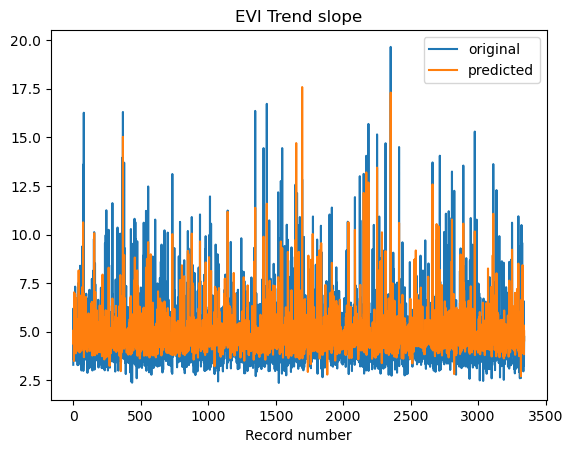

In [14]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend slope")

pyplot.legend()

pyplot.savefig(r'.\figs\version1\neg_predicted_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

pyplot.show()

In [66]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

#image.render(r'.\figs\pos_decision_tree6.png', format = format)
image.render(r'.\figs\version5\neg_decision_tree_m{y}_v1.png'.format(y=len(x)), format = format)

#-#image

'figs\\version5\\neg_decision_tree_m9_v1.png.png'